In [2]:
import tensorflow as tf
import keras as kr
import numpy as np
import pandas as pd
import matplotlib as mat
import cv2
print(cv2.__version__)
from tensorflow.keras import layers, models
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

4.9.0


c:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Use Input layer here
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [4]:
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [2]:
def train_images():
    model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

In [3]:
from tensorflow.keras.datasets import mnist

data = mnist.load_data()


# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = data
# Reshape the data and normalize it
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255
len(train_images)


60000

## PIXEL INTENSITY

In [4]:
# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

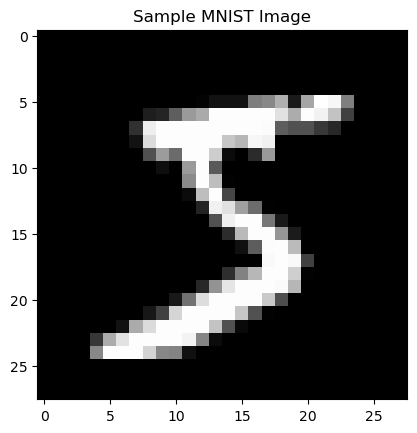

Average pixel intensity of the first image: 0.0005
Average pixel intensity of the training set: 0.0005
Minimum pixel intensity in the training set: 0.0
Maximum pixel intensity in the training set: 0.003921568859368563


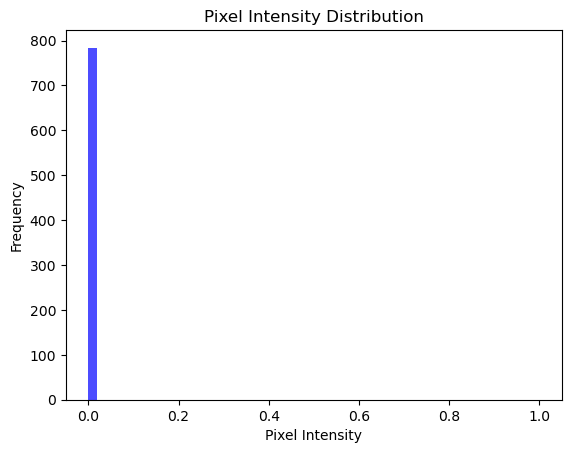

In [8]:
import matplotlib.pyplot as plt


# Analyze pixel intensity for the first image
first_image = train_images[0]

# Show the first image
plt.imshow(first_image, cmap='gray')
plt.title('Sample MNIST Image')
plt.show()

# Calculate the average pixel intensity of the first image
average_intensity = np.mean(first_image)
print(f"Average pixel intensity of the first image: {average_intensity:.4f}")

# Calculate pixel intensity statistics for all training images
average_intensity_train = np.mean(train_images)
min_intensity_train = np.min(train_images)
max_intensity_train = np.max(train_images)

print(f"Average pixel intensity of the training set: {average_intensity_train:.4f}")
print(f"Minimum pixel intensity in the training set: {min_intensity_train}")
print(f"Maximum pixel intensity in the training set: {max_intensity_train}")

# Function to plot pixel intensity distribution of an image
def plot_pixel_intensity(image):
    plt.hist(image.flatten(), bins=50, range=[0,1], color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Plot the pixel intensity distribution of the first image
plot_pixel_intensity(first_image)

In [5]:
print(train_images[0].shape)

(28, 28, 1)


## HOG FEATURE

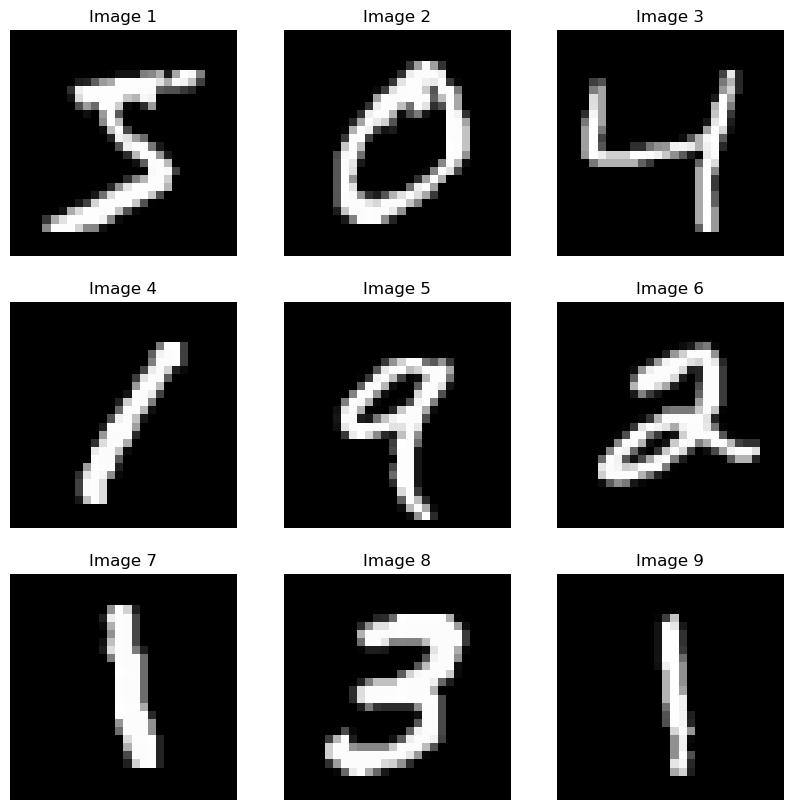

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute gradients in x and y directions
def compute_gradients(img):
    grad_x = np.roll(img, -1, axis=1) - img  # x-direction gradient
    grad_y = np.roll(img, -1, axis=0) - img  # y-direction gradient
    return grad_x, grad_y

# Function to compute HOG descriptor for a single image
def hog_descriptor(img):
    grad_x, grad_y = compute_gradients(img)  # Get gradients
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)  # Gradient magnitude
    grad_orient = np.arctan2(grad_y, grad_x)  # Gradient orientation
    
    # Simplified HOG by computing histogram of gradient orientations
    hist, _ = np.histogram(grad_orient, bins=9, range=(0, np.pi))
    
    return hist / np.sum(hist)  # Normalize histogram

# Assuming train_images is a list of 28x28 images, extract HOG features
hog_features_train = [hog_descriptor(img) for img in train_images]

# Extract HOG features for test images as well
hog_features_test = [hog_descriptor(img) for img in test_images]

# Display a few images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')

# Show the images
plt.show()


## EDGE DETECTION

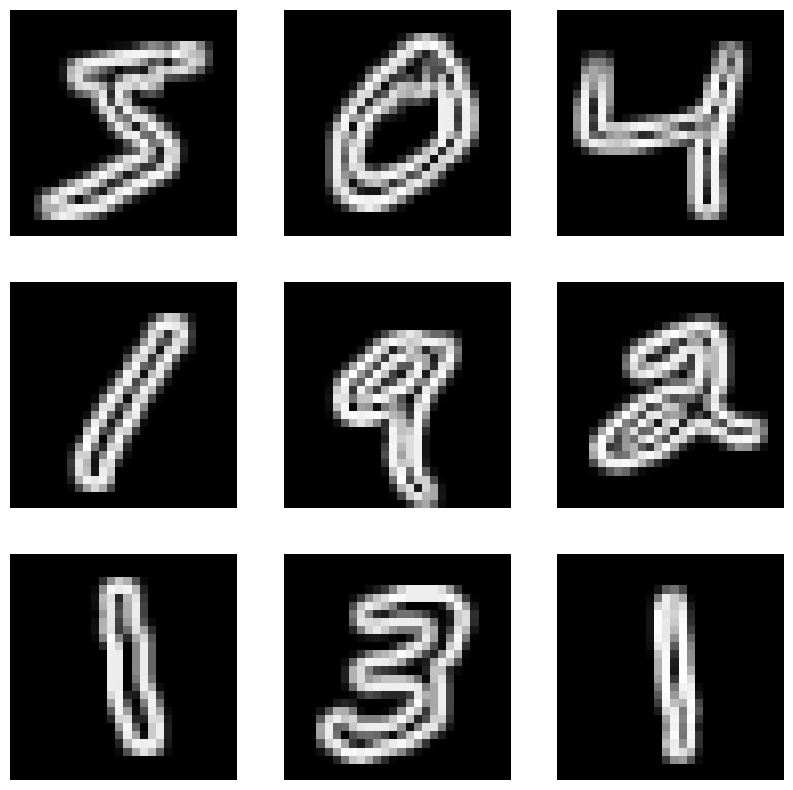

In [11]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Assuming you have the following variables:
# train_images: normalized MNIST training images (28x28)
# test_images: normalized MNIST testing images (28x28)

# Define the Sobel operators
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Apply Sobel Edge Detection to all training images
train_edges = []
for img in train_images:
    # Ensure img is a 2-D array (grayscale image)
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)  # Convert to grayscale
    
    edges_x = convolve2d(img, sobel_x, mode='same')
    edges_y = convolve2d(img, sobel_y, mode='same')
    edges = np.sqrt(edges_x ** 2 + edges_y ** 2)
    edges = edges / edges.max()  # Normalize the edges
    train_edges.append(edges)

# Visualize some edge-detected images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_edges[i], cmap='gray')
    plt.axis('off')
plt.show()

## CORNER DETECTION

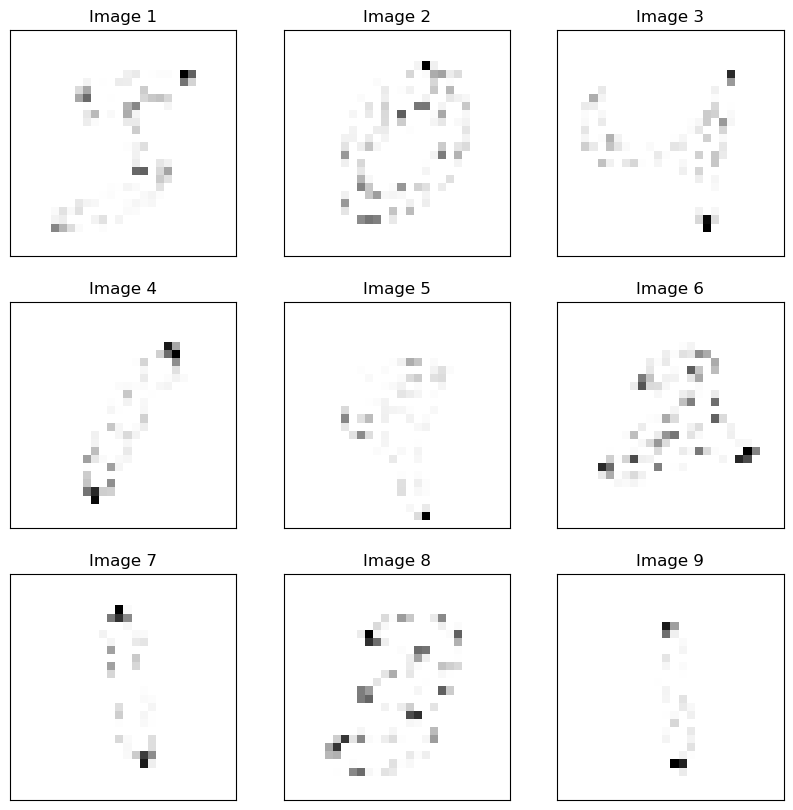

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def apply_harris_corner_detection(image):
    dx = np.gradient(image, axis=0)
    dy = np.gradient(image, axis=1)
    dxx = np.gradient(dx, axis=0)
    dxy = np.gradient(dx, axis=1)
    dyx = np.gradient(dy, axis=0)
    dyy = np.gradient(dy, axis=1)
    k = 0.05
    det = dxx * dyy - dxy * dyx
    trace = dxx + dyy
    corners = det - k * (trace ** 2)
    return corners / corners.max()

train_corners = np.array([apply_harris_corner_detection(img) for img in train_images])
test_corners = np.array([apply_harris_corner_detection(img) for img in test_images])

train_corners = np.expand_dims(train_corners, axis=-1)
test_corners = np.expand_dims(test_corners, axis=-1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_corners[i].squeeze(), cmap='Greys', vmin=0, vmax=1)
    plt.gca().set_facecolor('white')  # Set background to white
    plt.title(f"Image {i+1}")
    plt.xticks([])
    plt.yticks([])
plt.show()

## TEXTURE FEATURE

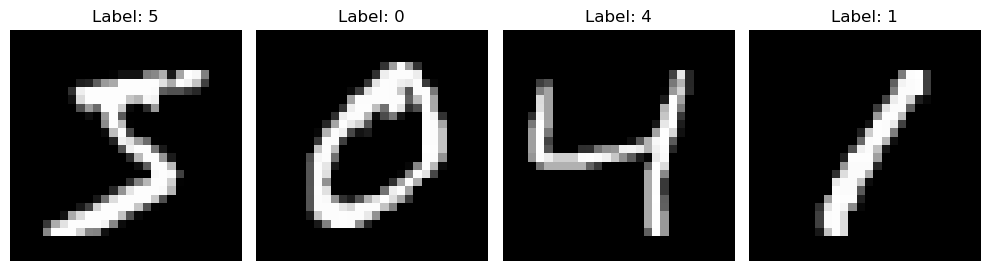

In [13]:
import matplotlib.pyplot as plt

# Extracting texture features (in this case, we'll use the pixel values as features)
train_features = train_images.reshape((train_images.shape[0], -1))
test_features = test_images.reshape((test_images.shape[0], -1))

# Displaying a few images
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## ZERNIKE MOMENTS

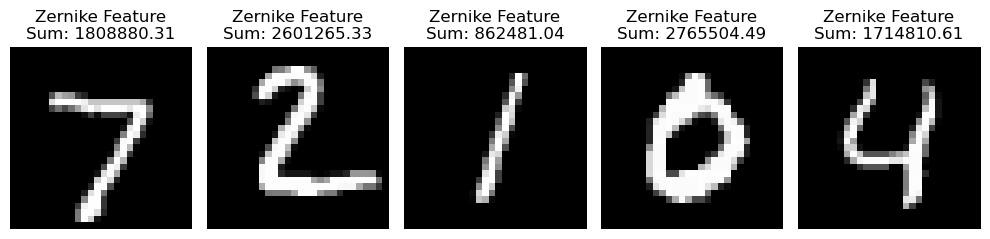

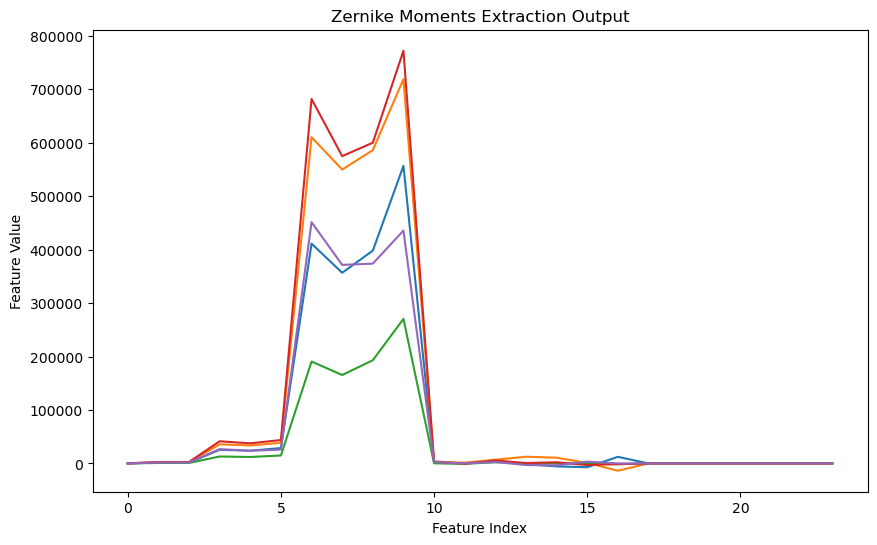

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def extract_zernike_moments(image):
    radius = min(image.shape[0], image.shape[1]) // 2
    order = 10  # Adjust order as needed

    moments = cv2.moments(image, binaryImage=True)
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])

    # Compute Zernike moments (you may need a specific library like mahotas for accurate Zernike moments)
    zernike_moments = cv2.moments(image, binaryImage=True)  # Placeholder, as OpenCV doesn't support Zernike
    return np.array(list(zernike_moments.values()))

# Apply Zernike moments to training and testing data
train_zernike_features = np.array([extract_zernike_moments(image) for image in train_images])
test_zernike_features = np.array([extract_zernike_moments(image) for image in test_images])

# Display function to visualize the images and the extracted features
def display_images_with_features(images, features, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Zernike Feature\nSum: {np.sum(features[i]):.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a few sample images along with their Zernike features
display_images_with_features(test_images[:5], test_zernike_features[:5])

# Plot the output of Zernike moments extraction
plt.figure(figsize=(10, 6))
plt.plot(test_zernike_features[:5].T)
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title('Zernike Moments Extraction Output')
plt.show()

## DEFINE & TRAIN MODEL

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

# Define the model
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.8618 - loss: 0.4337 - val_accuracy: 0.9856 - val_loss: 0.0459
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9758 - loss: 0.0816 - val_accuracy: 0.9895 - val_loss: 0.0335
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9845 - loss: 0.0536 - val_accuracy: 0.9897 - val_loss: 0.0341
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9865 - loss: 0.0444 - val_accuracy: 0.9916 - val_loss: 0.0247
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9882 - loss: 0.0383 - val_accuracy: 0.9918 - val_loss: 0.0248


In [16]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9884 - loss: 0.0321
Test accuracy: 0.9918


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Predicted label: 7
True label: 7


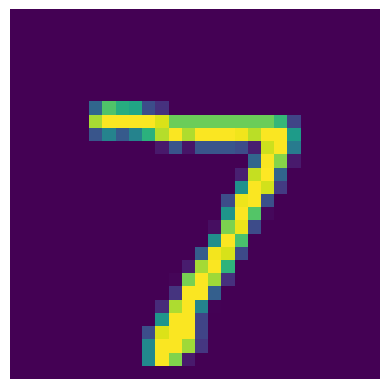

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Predicting the first test image
predictions = model.predict(test_images)
predicted_label = np.argmax(predictions[0])
true_label = test_labels[0]

print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")

# Displaying the first test image
plt.imshow(test_images[0])
plt.axis('off')
plt.show()

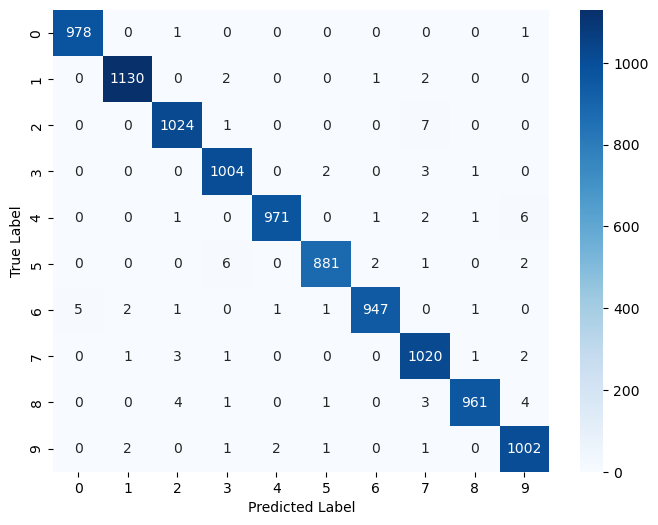

In [19]:
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

# Generate predictions
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
# Train the model and save the training history
history = model.fit(train_images, train_labels, 
                    epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9912 - loss: 0.0305 - val_accuracy: 0.9922 - val_loss: 0.0259
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9907 - loss: 0.0293 - val_accuracy: 0.9915 - val_loss: 0.0253
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9925 - loss: 0.0238 - val_accuracy: 0.9921 - val_loss: 0.0263
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9936 - loss: 0.0225 - val_accuracy: 0.9924 - val_loss: 0.0241
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9930 - loss: 0.0206 - val_accuracy: 0.9923 - val_loss: 0.0254
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.9931 - val_loss: 0.0270
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9947 - loss: 0.0157 - val_accuracy: 0.9915 - val_loss: 0.0305
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9945 -

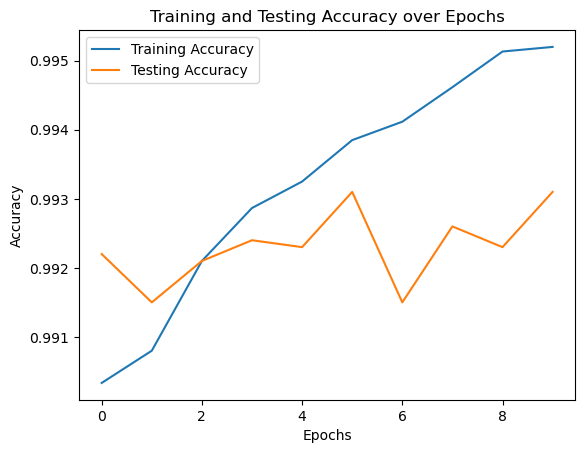

Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,104 (2.58 MB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 450,070 (1.72 MB)

None


In [21]:
import matplotlib.pyplot as plt

# Retrieve the accuracy values for training and validation
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy over epochs
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

# Print the model summary
print("Model Summary:")
print(model.summary())